# Modellvergleich: LSTM vs. Transformer

Dieses Notebook vergleicht die beiden Architekturen:
- **LSTM**: Rekurrentes Netzwerk, sequentielle Verarbeitung
- **Transformer**: Self-Attention, parallele Verarbeitung

Verglichen werden:
1. Parameter (Anzahl, Struktur)
2. Architektur-Unterschiede
3. Logits und Vorhersagen
4. Generierungsverhalten
5. Attention-Weights (nur Transformer)

In [2]:
import sys
from pathlib import Path

# src-Verzeichnis zum Python-Path hinzufuegen
src_path = Path("..").resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Stil setzen
plt.style.use('dark_background')
sns.set_theme(style='darkgrid')

print(f"Python-Path: {src_path}")
print("Bibliotheken geladen!")

Python-Path: C:\SDK\lm-stack\languageModel\src
Bibliotheken geladen!


## 1. Modelle laden

In [3]:
from training.training_lstm import load_model as load_lstm
from training.training_transformer import load_transformer_model as load_transformer

# Modell-Pfade
lstm_dir = Path("../../dist/lstm_model")
transformer_dir = Path("../../dist/transformer_model")

# Modelle laden
models_loaded = {}

if lstm_dir.exists():
    print("=" * 50)
    print("LSTM-Modell laden...")
    print("=" * 50)
    lstm_model, lstm_tokenizer = load_lstm(str(lstm_dir))
    models_loaded['lstm'] = (lstm_model, lstm_tokenizer)
else:
    print("LSTM-Modell nicht gefunden! Bitte erst trainieren (Option 1 in main.py)")

print()

if transformer_dir.exists():
    print("=" * 50)
    print("Transformer-Modell laden...")
    print("=" * 50)
    transformer_model, transformer_tokenizer = load_transformer(str(transformer_dir))
    models_loaded['transformer'] = (transformer_model, transformer_tokenizer)
else:
    print("Transformer-Modell nicht gefunden! Bitte erst trainieren (Option 2 in main.py)")

print(f"\nGeladene Modelle: {list(models_loaded.keys())}")

LSTM-Modell laden...
📂 Config geladen: ..\..\dist\lstm_model\config.json
🧠 Modell erstellt:
   - Embedding: 69 Wörter -> 32D Vektoren
   - LSTM: 32D -> 64D hidden
   - Output: 64D -> 69 Logits
📂 Modell geladen: ..\..\dist\lstm_model\model.pt
📂 Tokenizer geladen: ..\..\dist\lstm_model\tokenizer.json (69 Wörter)

✅ Modell bereit für Inferenz!

Transformer-Modell laden...
🤖 MiniGPT erstellt:
   - Vokabular: 70 Tokens
   - Embedding: 64D
   - Attention Heads: 1
   - Transformer Layers: 2
✅ Transformer-Modell geladen aus: ..\..\dist\transformer_model

Geladene Modelle: ['lstm', 'transformer']


## 2. Parameter-Vergleich

Vergleicht die Anzahl und Verteilung der trainierbaren Parameter.

In [4]:
def count_parameters(model):
    """Zaehlt Parameter pro Layer und gesamt."""
    layer_params = {}
    total = 0
    
    for name, param in model.named_parameters():
        count = param.numel()
        layer_params[name] = count
        total += count
    
    return layer_params, total


def print_parameter_comparison():
    """Druckt einen detaillierten Parameter-Vergleich."""
    print("=" * 80)
    print("PARAMETER-VERGLEICH: LSTM vs. Transformer")
    print("=" * 80)
    
    results = {}
    
    for name, (model, _) in models_loaded.items():
        layer_params, total = count_parameters(model)
        results[name] = {'layers': layer_params, 'total': total}
        
        print(f"\n{'=' * 40}")
        print(f"{name.upper()} - {total:,} Parameter gesamt")
        print(f"{'=' * 40}")
        
        # Gruppiere nach Komponente
        components = {}
        for layer_name, count in layer_params.items():
            # Extrahiere Komponenten-Name (z.B. 'embedding', 'lstm', 'blocks.0.attention')
            parts = layer_name.split('.')
            component = parts[0] if len(parts) == 2 else '.'.join(parts[:2])
            components[component] = components.get(component, 0) + count
        
        for component, count in sorted(components.items(), key=lambda x: -x[1]):
            pct = count / total * 100
            bar = '#' * int(pct / 2)
            print(f"  {component:<25} {count:>10,} ({pct:>5.1f}%) {bar}")
    
    return results

param_results = print_parameter_comparison()

PARAMETER-VERGLEICH: LSTM vs. Transformer

LSTM - 31,781 Parameter gesamt
  lstm                          25,088 ( 78.9%) #######################################
  fc                             4,485 ( 14.1%) #######
  embedding                      2,208 (  6.9%) ###

TRANSFORMER - 109,056 Parameter gesamt
  blocks.0                      49,984 ( 45.8%) ######################
  blocks.1                      49,984 ( 45.8%) ######################
  token_embedding                4,480 (  4.1%) ##
  lm_head                        4,480 (  4.1%) ##
  ln_final                         128 (  0.1%) 


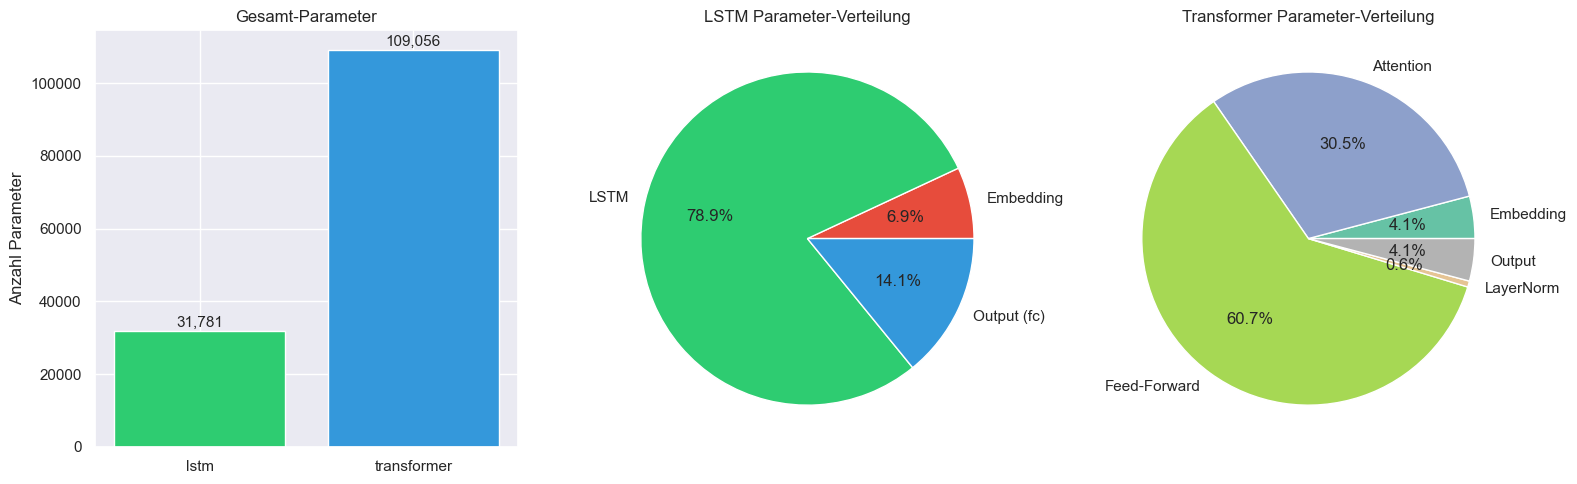

In [5]:
def plot_parameter_comparison(param_results):
    """Visualisiert den Parameter-Vergleich."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Gesamt-Vergleich (Bar)
    ax1 = axes[0]
    names = list(param_results.keys())
    totals = [param_results[n]['total'] for n in names]
    colors = ['#2ecc71', '#3498db']
    
    bars = ax1.bar(names, totals, color=colors[:len(names)])
    ax1.set_ylabel('Anzahl Parameter')
    ax1.set_title('Gesamt-Parameter')
    
    for bar, total in zip(bars, totals):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
                f'{total:,}', ha='center', va='bottom', fontsize=11)
    
    # 2. LSTM Pie Chart
    ax2 = axes[1]
    if 'lstm' in param_results:
        lstm_layers = param_results['lstm']['layers']
        # Gruppiere
        groups = {'Embedding': 0, 'LSTM': 0, 'Output (fc)': 0}
        for name, count in lstm_layers.items():
            if 'embedding' in name:
                groups['Embedding'] += count
            elif 'lstm' in name:
                groups['LSTM'] += count
            else:
                groups['Output (fc)'] += count
        
        ax2.pie(groups.values(), labels=groups.keys(), autopct='%1.1f%%',
               colors=['#e74c3c', '#2ecc71', '#3498db'])
        ax2.set_title('LSTM Parameter-Verteilung')
    
    # 3. Transformer Pie Chart
    ax3 = axes[2]
    if 'transformer' in param_results:
        trans_layers = param_results['transformer']['layers']
        # Gruppiere
        groups = {'Embedding': 0, 'Positional': 0, 'Attention': 0, 
                  'Feed-Forward': 0, 'LayerNorm': 0, 'Output': 0}
        for name, count in trans_layers.items():
            if 'token_embedding' in name:
                groups['Embedding'] += count
            elif 'pos' in name:
                groups['Positional'] += count
            elif 'attention' in name or 'proj' in name:
                groups['Attention'] += count
            elif 'ff' in name:
                groups['Feed-Forward'] += count
            elif 'norm' in name or 'ln' in name:
                groups['LayerNorm'] += count
            else:
                groups['Output'] += count
        
        # Nur nicht-leere Gruppen
        groups = {k: v for k, v in groups.items() if v > 0}
        ax3.pie(groups.values(), labels=groups.keys(), autopct='%1.1f%%',
               colors=plt.cm.Set2(np.linspace(0, 1, len(groups))))
        ax3.set_title('Transformer Parameter-Verteilung')
    
    plt.tight_layout()
    plt.show()

plot_parameter_comparison(param_results)

## 3. Architektur-Vergleich

| Aspekt | LSTM | Transformer |
|--------|------|-------------|
| Verarbeitung | Sequentiell | Parallel |
| Kontext | Hidden State | Self-Attention |
| Langzeit-Abhaengigkeiten | Begrenzt (Vanishing Gradient) | Direkt (Attention) |
| Positionsinformation | Implizit (Reihenfolge) | Explizit (Positional Encoding) |
| Trainingsgeschwindigkeit | Langsamer | Schneller (parallelisierbar) |

In [6]:
def print_architecture_comparison():
    """Druckt die Architektur beider Modelle."""
    print("=" * 80)
    print("ARCHITEKTUR-VERGLEICH")
    print("=" * 80)
    
    if 'lstm' in models_loaded:
        model, tokenizer = models_loaded['lstm']
        print(f"\n{'LSTM':-^40}")
        print(f"  Vokabular:     {model.vocab_size} Woerter")
        print(f"  Embedding Dim: {model.embedding_dim}")
        print(f"  Hidden Dim:    {model.hidden_dim}")
        print(f"\n  Architektur:")
        print(f"    Input -> Embedding({model.vocab_size}, {model.embedding_dim})")
        print(f"          -> LSTM({model.embedding_dim}, {model.hidden_dim})")
        print(f"          -> Linear({model.hidden_dim}, {model.vocab_size})")
        print(f"          -> Logits")
    
    if 'transformer' in models_loaded:
        model, tokenizer = models_loaded['transformer']
        print(f"\n{'TRANSFORMER (MiniGPT)':-^40}")
        print(f"  Vokabular:     {model.vocab_size} Woerter")
        print(f"  Embedding Dim: {model.embed_dim}")
        print(f"  Num Layers:    {len(model.blocks)}")
        print(f"  Num Heads:     {model.blocks[0].attention.num_heads}")
        print(f"\n  Architektur:")
        print(f"    Input -> TokenEmbedding({model.vocab_size}, {model.embed_dim})")
        print(f"          -> PositionalEncoding")
        for i in range(len(model.blocks)):
            print(f"          -> TransformerBlock {i+1}:")
            print(f"               - MultiHeadAttention (Q, K, V)")
            print(f"               - LayerNorm + Residual")
            print(f"               - FeedForward (GELU)")
            print(f"               - LayerNorm + Residual")
        print(f"          -> LayerNorm")
        print(f"          -> Linear({model.embed_dim}, {model.vocab_size})")
        print(f"          -> Logits")

print_architecture_comparison()

ARCHITEKTUR-VERGLEICH

------------------LSTM------------------
  Vokabular:     69 Woerter
  Embedding Dim: 32
  Hidden Dim:    64

  Architektur:
    Input -> Embedding(69, 32)
          -> LSTM(32, 64)
          -> Linear(64, 69)
          -> Logits

---------TRANSFORMER (MiniGPT)----------
  Vokabular:     70 Woerter
  Embedding Dim: 64
  Num Layers:    2
  Num Heads:     1

  Architektur:
    Input -> TokenEmbedding(70, 64)
          -> PositionalEncoding
          -> TransformerBlock 1:
               - MultiHeadAttention (Q, K, V)
               - LayerNorm + Residual
               - FeedForward (GELU)
               - LayerNorm + Residual
          -> TransformerBlock 2:
               - MultiHeadAttention (Q, K, V)
               - LayerNorm + Residual
               - FeedForward (GELU)
               - LayerNorm + Residual
          -> LayerNorm
          -> Linear(64, 70)
          -> Logits


## 4. Logits-Vergleich

Vergleicht die Vorhersagen beider Modelle fuer dieselbe Eingabe.

In [7]:
def get_predictions(model, tokenizer, text, model_type='lstm'):
    """Holt Logits und Wahrscheinlichkeiten fuer eine Eingabe."""
    model.eval()
    tokens = tokenizer.encode(text)
    
    with torch.no_grad():
        input_tensor = torch.tensor(tokens).unsqueeze(0)
        logits = model(input_tensor)
        last_logits = logits[0, -1, :]  # Letzter Token
        probs = F.softmax(last_logits, dim=-1)
    
    return last_logits.numpy(), probs.numpy()


def compare_logits(text, top_k=10):
    """Vergleicht die Logits beider Modelle Side-by-Side."""
    print(f"\nEingabe: '{text}'")
    print("=" * 80)
    
    results = {}
    
    for name, (model, tokenizer) in models_loaded.items():
        logits, probs = get_predictions(model, tokenizer, text, name)
        top_indices = np.argsort(probs)[-top_k:][::-1]
        
        results[name] = {
            'logits': logits,
            'probs': probs,
            'top_indices': top_indices,
            'top_words': [tokenizer.idx_to_word.get(i, '?') for i in top_indices],
            'top_probs': probs[top_indices],
            'tokenizer': tokenizer
        }
    
    # Side-by-Side Ausgabe
    print(f"\n{'LSTM':<40} {'TRANSFORMER':<40}")
    print(f"{'-'*38:<40} {'-'*38:<40}")
    
    for i in range(top_k):
        lstm_str = ""
        trans_str = ""
        
        if 'lstm' in results:
            r = results['lstm']
            lstm_str = f"{i+1}. {r['top_words'][i]:<12} {r['top_probs'][i]*100:>6.2f}%"
        
        if 'transformer' in results:
            r = results['transformer']
            trans_str = f"{i+1}. {r['top_words'][i]:<12} {r['top_probs'][i]*100:>6.2f}%"
        
        print(f"{lstm_str:<40} {trans_str:<40}")
    
    return results

# Vergleiche fuer verschiedene Eingaben
test_texts = ["die katze", "der hund", "das kind spielt"]
comparison_results = {}

for text in test_texts:
    comparison_results[text] = compare_logits(text, top_k=8)


Eingabe: 'die katze'

LSTM                                     TRANSFORMER                             
--------------------------------------   --------------------------------------  
1. schläft       27.46%                  1. schläft       43.16%                 
2. jagt          27.31%                  2. sitzt         34.96%                 
3. trinkt        22.65%                  3. trinkt        10.88%                 
4. sitzt         21.09%                  4. jagt          10.06%                 
5. auf            0.06%                  5. im             0.11%                 
6. wedelt         0.06%                  6. katze          0.07%                 
7. frisst         0.06%                  7. frau           0.06%                 
8. spielplatz     0.06%                  8. blume          0.05%                 

Eingabe: 'der hund'

LSTM                                     TRANSFORMER                             
--------------------------------------   ------------

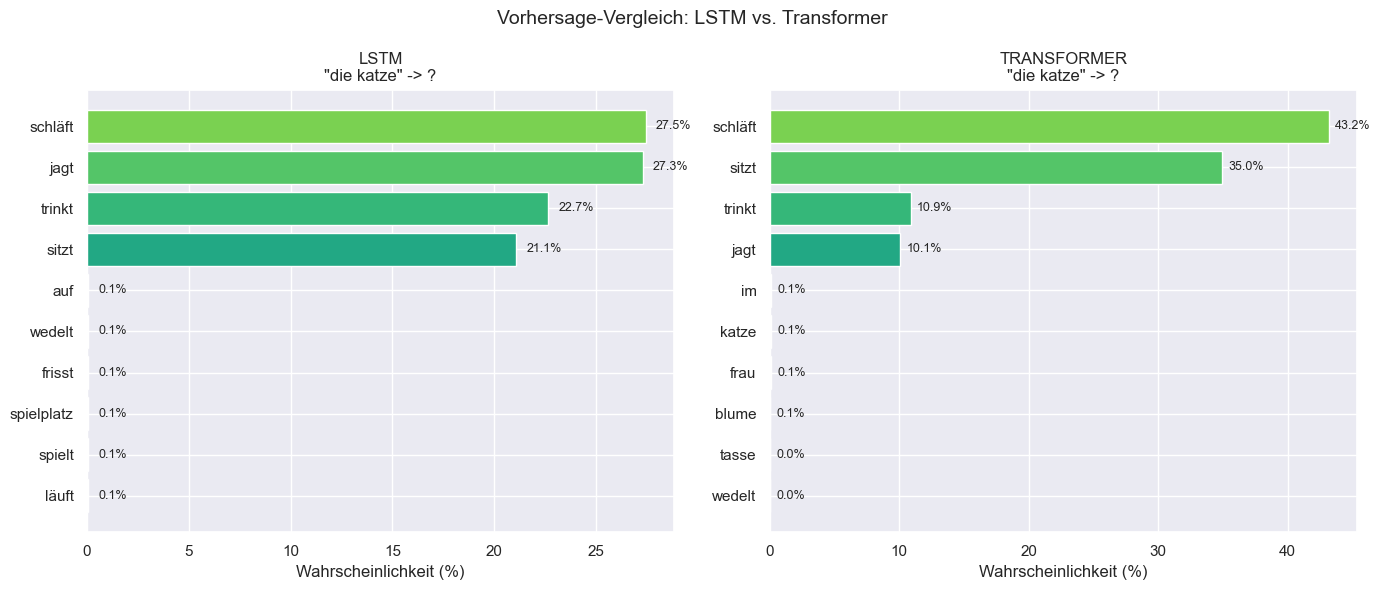

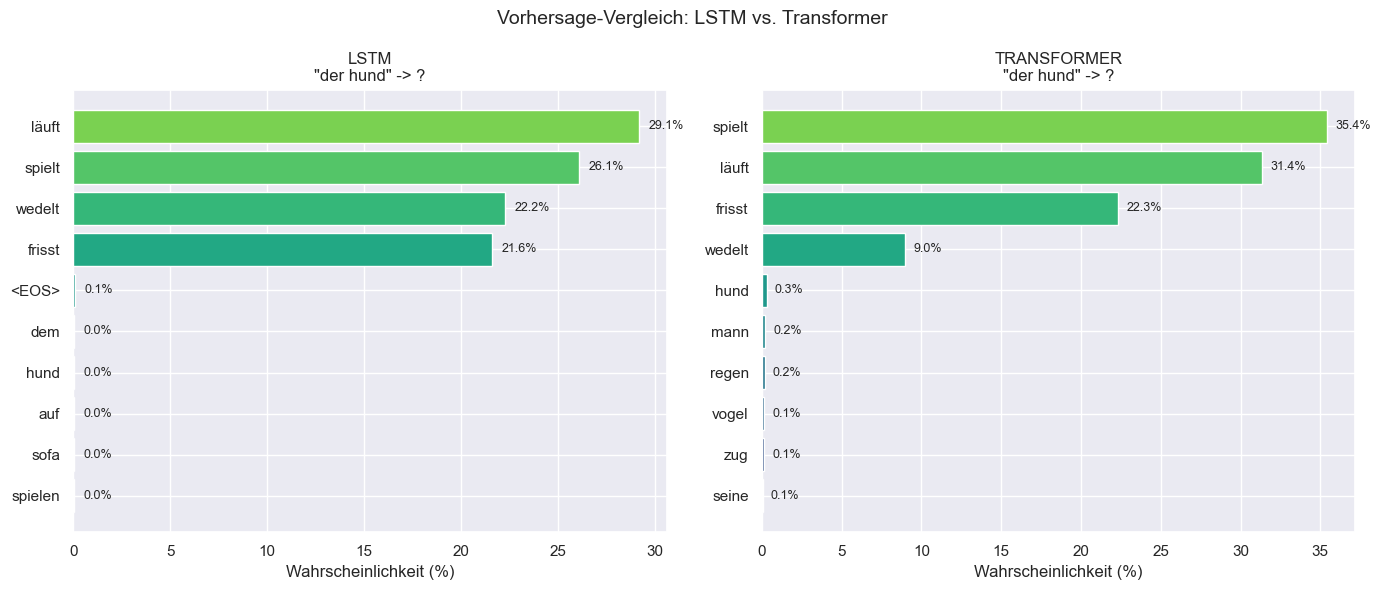

In [8]:
def plot_logits_comparison(text, top_k=12):
    """Visualisiert den Logits-Vergleich als Balkendiagramm."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    colors = {'lstm': '#2ecc71', 'transformer': '#3498db'}
    
    for idx, (name, (model, tokenizer)) in enumerate(models_loaded.items()):
        ax = axes[idx]
        logits, probs = get_predictions(model, tokenizer, text, name)
        
        top_indices = np.argsort(probs)[-top_k:][::-1]
        top_probs = probs[top_indices]
        top_words = [tokenizer.idx_to_word.get(i, '?')[:10] for i in top_indices]
        
        bars = ax.barh(range(top_k), top_probs * 100, 
                      color=plt.cm.viridis(np.linspace(0.8, 0.2, top_k)))
        ax.set_yticks(range(top_k))
        ax.set_yticklabels(top_words)
        ax.set_xlabel('Wahrscheinlichkeit (%)')
        ax.set_title(f'{name.upper()}\n"{text}" -> ?')
        ax.invert_yaxis()
        
        # Werte anzeigen
        for bar, prob in zip(bars, top_probs):
            ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                   f'{prob*100:.1f}%', va='center', fontsize=9)
    
    plt.suptitle(f'Vorhersage-Vergleich: LSTM vs. Transformer', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualisierung fuer verschiedene Eingaben
for text in ["die katze", "der hund"]:
    plot_logits_comparison(text, top_k=10)

## 5. Logits-Verteilung (Histogramm)

Zeigt wie die Logits ueber das gesamte Vokabular verteilt sind.

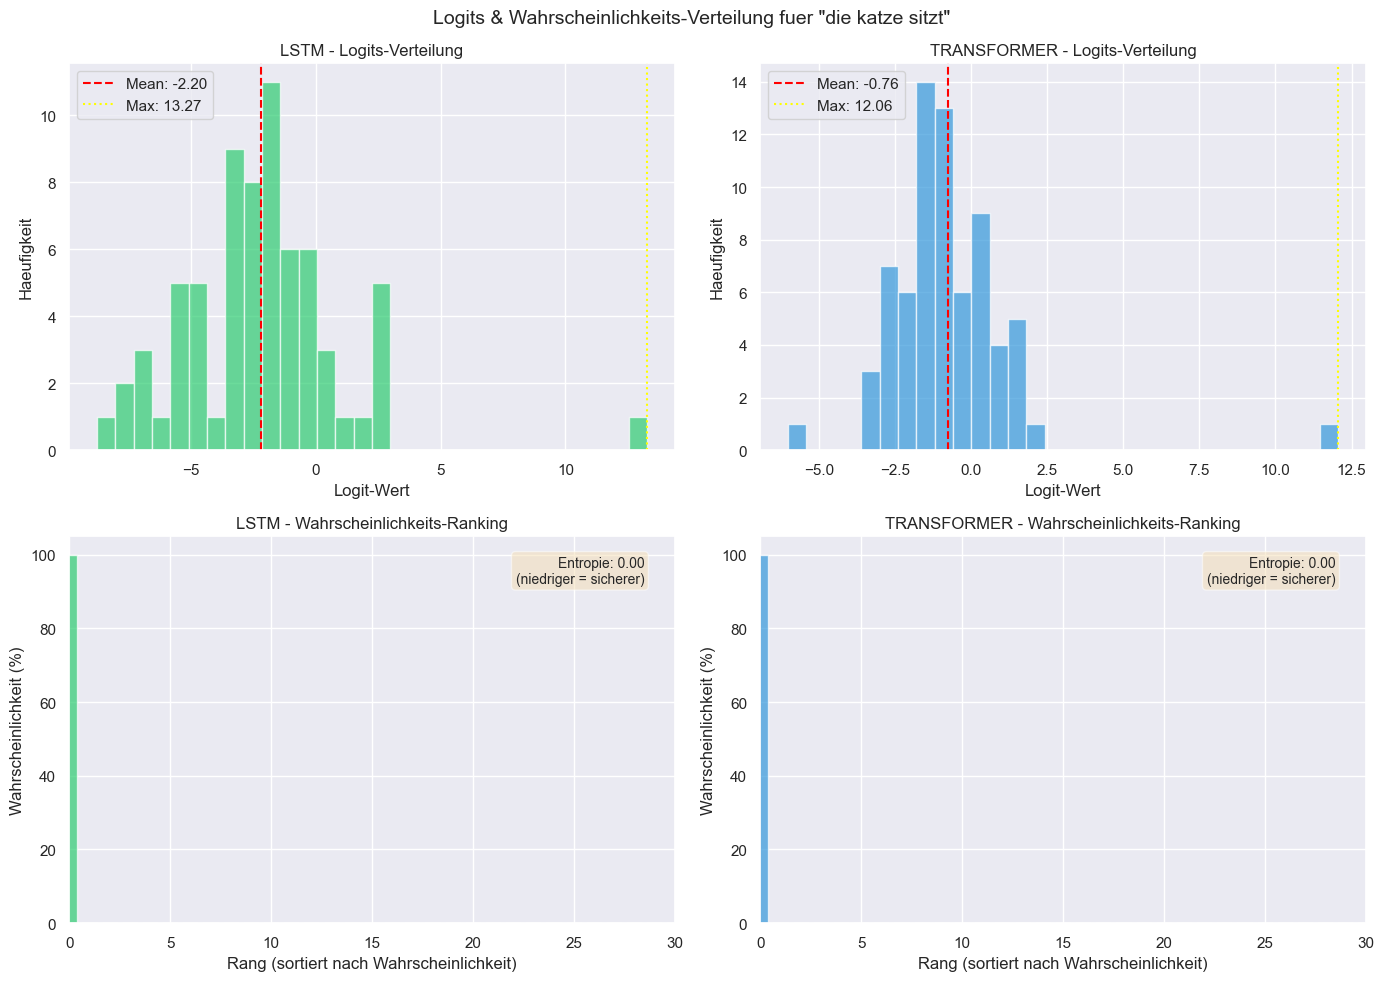

In [9]:
def plot_logits_distribution(text):
    """Vergleicht die Logits-Verteilung beider Modelle."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = {'lstm': '#2ecc71', 'transformer': '#3498db'}
    
    for idx, (name, (model, tokenizer)) in enumerate(models_loaded.items()):
        logits, probs = get_predictions(model, tokenizer, text, name)
        
        # Logits Histogramm
        ax1 = axes[0, idx]
        ax1.hist(logits, bins=30, color=colors[name], alpha=0.7, edgecolor='white')
        ax1.axvline(logits.mean(), color='red', linestyle='--', label=f'Mean: {logits.mean():.2f}')
        ax1.axvline(logits.max(), color='yellow', linestyle=':', label=f'Max: {logits.max():.2f}')
        ax1.set_xlabel('Logit-Wert')
        ax1.set_ylabel('Haeufigkeit')
        ax1.set_title(f'{name.upper()} - Logits-Verteilung')
        ax1.legend()
        
        # Wahrscheinlichkeits-Verteilung (sortiert)
        ax2 = axes[1, idx]
        sorted_probs = np.sort(probs)[::-1]
        ax2.bar(range(len(sorted_probs)), sorted_probs * 100, color=colors[name], alpha=0.7)
        ax2.set_xlabel('Rang (sortiert nach Wahrscheinlichkeit)')
        ax2.set_ylabel('Wahrscheinlichkeit (%)')
        ax2.set_title(f'{name.upper()} - Wahrscheinlichkeits-Ranking')
        ax2.set_xlim(0, 30)  # Nur Top-30 zeigen
        
        # Statistiken
        entropy = -np.sum(probs * np.log(probs + 1e-10))
        ax2.annotate(f'Entropie: {entropy:.2f}\n(niedriger = sicherer)',
                    xy=(0.95, 0.95), xycoords='axes fraction',
                    ha='right', va='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'Logits & Wahrscheinlichkeits-Verteilung fuer "{text}"', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_logits_distribution("die katze sitzt")

## 6. Generierungs-Vergleich

Vergleicht die generierten Texte beider Modelle.

In [10]:
def generate_text(model, tokenizer, start_text, max_tokens=8, temperature=1.0):
    """Generiert Text mit dem gegebenen Modell."""
    model.eval()
    tokens = tokenizer.encode(start_text)
    generated = tokens.copy()
    
    # EOS Token ID (falls vorhanden)
    eos_id = tokenizer.word_to_idx.get('<EOS>', tokenizer.word_to_idx.get(getattr(tokenizer, 'eos_token', '<EOS>'), -1))
    
    for _ in range(max_tokens):
        context = tokens[-10:] if len(tokens) > 10 else tokens
        
        with torch.no_grad():
            input_tensor = torch.tensor(context).unsqueeze(0)
            logits = model(input_tensor)
            last_logits = logits[0, -1, :] / temperature
            probs = F.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, 1).item()
        
        tokens.append(next_token)
        generated.append(next_token)
        
        if next_token == eos_id:
            break
    
    return tokenizer.decode(generated)


def compare_generation(start_texts, num_samples=3, temperature=0.8):
    """Vergleicht die Generierung beider Modelle."""
    print("=" * 80)
    print(f"GENERIERUNGS-VERGLEICH (Temperature={temperature})")
    print("=" * 80)
    
    for start_text in start_texts:
        print(f"\nStart: '{start_text}'")
        print("-" * 60)
        
        for name, (model, tokenizer) in models_loaded.items():
            print(f"  {name.upper()}:")
            for i in range(num_samples):
                generated = generate_text(model, tokenizer, start_text, 
                                         max_tokens=6, temperature=temperature)
                print(f"    {i+1}. {generated}")
        print()

# Generierung vergleichen
compare_generation(["die katze", "der hund", "das kind"], num_samples=3, temperature=0.8)

GENERIERUNGS-VERGLEICH (Temperature=0.8)

Start: 'die katze'
------------------------------------------------------------
  LSTM:
    1. die katze jagt die maus <EOS>
    2. die katze trinkt ihre milch <EOS>
    3. die katze sitzt auf dem tisch <EOS>
  TRANSFORMER:
    1. die katze schläft auf dem sofa milch schläft
    2. die katze sitzt auf dem tisch dem tisch
    3. die katze sitzt auf dem tisch dem tisch


Start: 'der hund'
------------------------------------------------------------
  LSTM:
    1. der hund frisst seinen knochen <EOS>
    2. der hund wedelt mit dem schwanz <EOS>
    3. der hund wedelt mit dem schwanz <EOS>
  TRANSFORMER:
    1. der hund wedelt mit dem schwanz zug kommt
    2. der hund spielt im park fährt auf dem
    3. der hund läuft im garten teller den baum


Start: 'das kind'
------------------------------------------------------------
  LSTM:
    1. das kind spielt im garten <EOS>
    2. das kind spielt im garten <EOS>
    3. das kind spielt im garten <EOS>
  

## 7. Attention-Visualisierung (nur Transformer)

Der Transformer hat Self-Attention - wir koennen sehen, worauf das Modell "achtet".

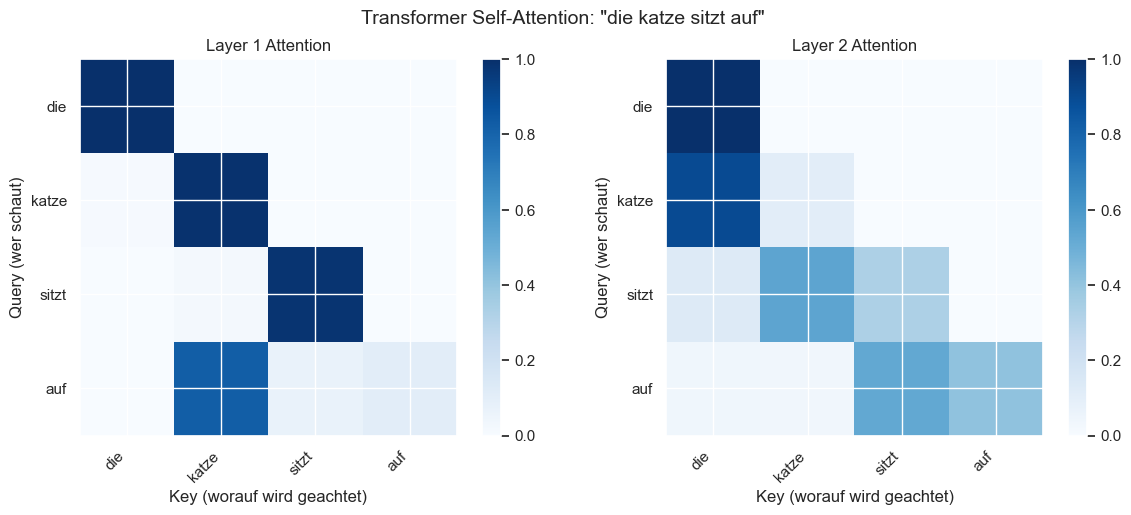


Hinweis: LSTM hat keine Attention-Weights.
Es verwendet stattdessen einen Hidden State, der sequentiell aktualisiert wird.


In [11]:
def visualize_transformer_attention(text):
    """Visualisiert die Attention-Weights des Transformers."""
    if 'transformer' not in models_loaded:
        print("Transformer-Modell nicht geladen!")
        return
    
    model, tokenizer = models_loaded['transformer']
    model.eval()
    
    tokens = tokenizer.encode(text)
    words = text.lower().split()
    
    with torch.no_grad():
        input_tensor = torch.tensor(tokens).unsqueeze(0)
        _ = model(input_tensor)
    
    # Attention Weights holen
    attention_weights = model.get_attention_weights()
    num_layers = len(attention_weights)
    
    fig, axes = plt.subplots(1, num_layers, figsize=(6*num_layers, 5))
    if num_layers == 1:
        axes = [axes]
    
    for layer_idx, layer_weights in enumerate(attention_weights):
        ax = axes[layer_idx]
        
        # Mittelwert ueber alle Heads
        avg_weights = layer_weights[0].mean(dim=0).numpy()  # [seq, seq]
        
        im = ax.imshow(avg_weights, cmap='Blues')
        ax.set_xticks(range(len(words)))
        ax.set_yticks(range(len(words)))
        ax.set_xticklabels(words, rotation=45, ha='right')
        ax.set_yticklabels(words)
        ax.set_xlabel('Key (worauf wird geachtet)')
        ax.set_ylabel('Query (wer schaut)')
        ax.set_title(f'Layer {layer_idx + 1} Attention')
        plt.colorbar(im, ax=ax)
    
    plt.suptitle(f'Transformer Self-Attention: "{text}"', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # LSTM hat keine Attention - Hinweis
    print("\nHinweis: LSTM hat keine Attention-Weights.")
    print("Es verwendet stattdessen einen Hidden State, der sequentiell aktualisiert wird.")

visualize_transformer_attention("die katze sitzt auf")

## 8. Embedding-Vergleich

Vergleicht die gelernten Embeddings beider Modelle.

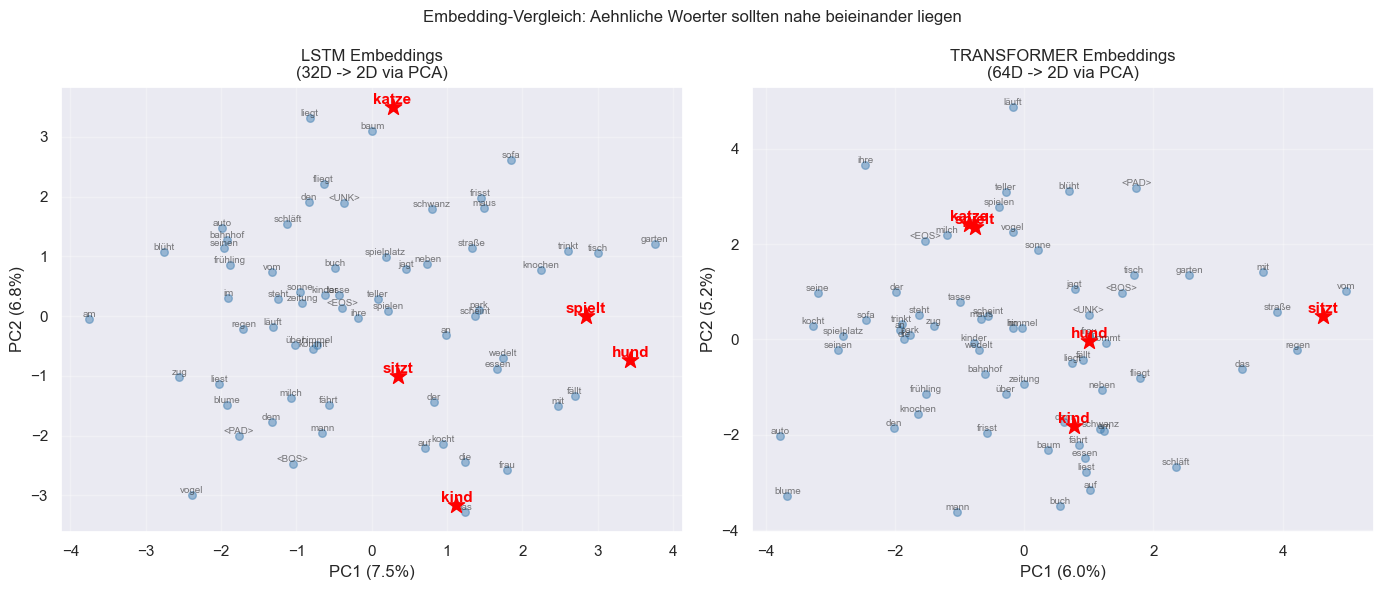


EMBEDDING-DISTANZEN zwischen ausgewaehlten Woertern

Wortpaar            |        LSTM        Cosinus |        LSTM        Euklid |    TRANSFORMER     Cosinus |    TRANSFORMER     Euklid 
--------------------|---------------------|---------------------|---------------------|---------------------
katze <-> hund      |       0.9352        |       8.9442        |       0.8301        |       9.9831        
katze <-> kind      |       1.2203        |       10.2869       |       1.0126        |       10.2103       
katze <-> sitzt     |       0.8981        |       8.7717        |       1.0518        |       11.2846       
katze <-> spielt    |       0.9214        |       9.0633        |       0.9839        |       10.3555       
hund <-> kind      |       0.9468        |       8.9216        |       0.9126        |       10.9489       
hund <-> sitzt     |       0.9510        |       8.8850        |       0.8352        |       11.1762       
hund <-> spielt    |       0.7813        |       8

In [12]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from itertools import combinations

def compare_embeddings(words_to_highlight=None):
    """Vergleicht die Embeddings beider Modelle mit PCA und berechnet Distanzen."""
    if words_to_highlight is None:
        words_to_highlight = ['katze', 'hund', 'kind', 'die', 'der', 'das']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    embedding_data = {}  # Speichert Embeddings für Distanzberechnung
    
    for idx, (name, (model, tokenizer)) in enumerate(models_loaded.items()):
        ax = axes[idx]
        
        # Embeddings extrahieren
        if name == 'lstm':
            embeddings = model.embedding.weight.detach().numpy()
        else:  # transformer
            embeddings = model.token_embedding.weight.detach().numpy()
        
        # Speichere für Distanzberechnung
        word_to_idx = {tokenizer.idx_to_word.get(i, f'[{i}]'): i for i in range(len(embeddings))}
        embedding_data[name] = {
            'embeddings': embeddings,
            'word_to_idx': word_to_idx,
            'tokenizer': tokenizer
        }
        
        # PCA
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        
        # Plotten
        ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                  alpha=0.5, s=30, c='steelblue')
        
        # Woerter beschriften
        for i in range(len(embeddings)):
            word = tokenizer.idx_to_word.get(i, f'[{i}]')
            x, y = embeddings_2d[i]
            
            if word in words_to_highlight:
                ax.scatter([x], [y], s=150, c='red', marker='*', zorder=5)
                ax.annotate(word, (x, y), fontsize=11, fontweight='bold',
                           color='red', ha='center', va='bottom')
            else:
                ax.annotate(word, (x, y), fontsize=7, alpha=0.6,
                           ha='center', va='bottom')
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        ax.set_title(f'{name.upper()} Embeddings\n({embeddings.shape[1]}D -> 2D via PCA)')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Embedding-Vergleich: Aehnliche Woerter sollten nahe beieinander liegen', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Distanzberechnung zwischen Wortpaaren
    print("\n" + "=" * 100)
    print("EMBEDDING-DISTANZEN zwischen ausgewaehlten Woertern")
    print("=" * 100)
    
    # Finde gemeinsame Wörter in beiden Modellen
    available_words = []
    for word in words_to_highlight:
        in_both = True
        for name in embedding_data:
            if word not in embedding_data[name]['word_to_idx']:
                in_both = False
                break
        if in_both:
            available_words.append(word)
    
    if len(available_words) < 2:
        print("Nicht genug gemeinsame Woerter fuer Distanzberechnung gefunden.")
        return
    
    # Berechne Distanzen für alle Wortpaare
    word_pairs = list(combinations(available_words, 2))
    
    # Header
    print(f"\n{'Wortpaar':<20}", end="")
    for name in embedding_data:
        print(f"| {name.upper():^18} Cosinus | {name.upper():^18} Euklid ", end="")
    print()
    print("-" * 20 + ("|" + "-" * 21 + "|" + "-" * 21) * len(embedding_data))
    
    # Distanzen pro Wortpaar
    for word1, word2 in word_pairs:
        print(f"{word1} <-> {word2:<10}", end="")
        
        for name in embedding_data:
            data = embedding_data[name]
            idx1 = data['word_to_idx'][word1]
            idx2 = data['word_to_idx'][word2]
            
            emb1 = data['embeddings'][idx1].reshape(1, -1)
            emb2 = data['embeddings'][idx2].reshape(1, -1)
            
            # Cosinus-Ähnlichkeit (1 - similarity = distance)
            cos_sim = cosine_similarity(emb1, emb2)[0, 0]
            cos_dist = 1 - cos_sim
            
            # Euklidische Distanz
            euc_dist = euclidean_distances(emb1, emb2)[0, 0]
            
            print(f"| {cos_dist:^19.4f} | {euc_dist:^19.4f} ", end="")
        print()
    
    # Statistiken
    print("\n" + "-" * 100)
    print("Legende:")
    print("  - Cosinus-Distanz: 0 = identisch, 2 = entgegengesetzt (berechnet als 1 - Cosinus-Aehnlichkeit)")
    print("  - Euklidische Distanz: Geometrischer Abstand im Embedding-Raum")
    print("  - Niedrigere Werte = aehnlichere Embeddings")

compare_embeddings(['katze', 'hund', 'kind', 'sitzt', 'laeuft', 'spielt'])

## 9. Zusammenfassung

| Merkmal | LSTM | Transformer |
|---------|------|-------------|
| Architektur | Rekurrent (sequentiell) | Self-Attention (parallel) |
| Parameter | Weniger | Mehr (durch Attention) |
| Kontext-Laenge | Begrenzt durch Hidden State | Theoretisch unbegrenzt |
| Training | Langsamer (nicht parallelisierbar) | Schneller |
| Interpretierbarkeit | Schwieriger | Attention-Weights zeigen Fokus |
| Moderne Nutzung | Seltener | Standard (GPT, BERT, etc.) |

In [13]:
def get_model_filesize(model_dir):
    """Berechnet die Dateigroesse des Modells."""
    model_path = Path(model_dir)
    total_size = 0
    files_info = {}
    
    if model_path.exists():
        for file in model_path.iterdir():
            if file.is_file():
                size = file.stat().st_size
                files_info[file.name] = size
                total_size += size
    
    return total_size, files_info


def format_size(size_bytes):
    """Formatiert Bytes in lesbare Groesse."""
    if size_bytes < 1024:
        return f"{size_bytes} B"
    elif size_bytes < 1024 * 1024:
        return f"{size_bytes / 1024:.1f} KB"
    else:
        return f"{size_bytes / (1024 * 1024):.2f} MB"


def print_summary():
    """Druckt eine Zusammenfassung des Vergleichs."""
    print("=" * 80)
    print("ZUSAMMENFASSUNG")
    print("=" * 80)
    
    if 'lstm' in models_loaded and 'transformer' in models_loaded:
        lstm_params = sum(p.numel() for p in models_loaded['lstm'][0].parameters())
        trans_params = sum(p.numel() for p in models_loaded['transformer'][0].parameters())
        
        print(f"\n  Parameter:")
        print(f"    LSTM:        {lstm_params:>10,}")
        print(f"    Transformer: {trans_params:>10,}")
        print(f"    Verhaeltnis: {trans_params/lstm_params:.2f}x")
        
        # Dateigroessen
        lstm_size, lstm_files = get_model_filesize(lstm_dir)
        trans_size, trans_files = get_model_filesize(transformer_dir)
        
        print(f"\n  Dateigroesse (gesamt):")
        print(f"    LSTM:        {format_size(lstm_size):>10}")
        print(f"    Transformer: {format_size(trans_size):>10}")
        print(f"    Verhaeltnis: {trans_size/lstm_size:.2f}x" if lstm_size > 0 else "")
        
        print(f"\n  Dateigroesse (Details):")
        print(f"    LSTM:")
        for fname, fsize in sorted(lstm_files.items()):
            print(f"      {fname:<20} {format_size(fsize):>10}")
        print(f"    Transformer:")
        for fname, fsize in sorted(trans_files.items()):
            print(f"      {fname:<20} {format_size(fsize):>10}")
        
        print(f"\n  Architektur-Highlights:")
        print(f"    LSTM:        Embedding -> LSTM -> Linear")
        print(f"    Transformer: Embedding -> Positional -> N x (Attention + FFN) -> Linear")
        
        print(f"\n  Besonderheiten:")
        print(f"    LSTM:        Hidden State speichert Kontext sequentiell")
        print(f"    Transformer: Attention erlaubt direkten Zugriff auf alle Positionen")
    
    print("\n" + "=" * 80)

print_summary()

ZUSAMMENFASSUNG

  Parameter:
    LSTM:            31,781
    Transformer:    109,056
    Verhaeltnis: 3.43x

  Dateigroesse (gesamt):
    LSTM:          152.3 KB
    Transformer:   463.4 KB
    Verhaeltnis: 3.04x

  Dateigroesse (Details):
    LSTM:
      MODEL_REPORT.md          1.1 KB
      config.json               109 B
      model.pt               126.9 KB
      tokenizer.json           2.7 KB
      training_loss.png       21.5 KB
    Transformer:
      MODEL_REPORT.md          1.9 KB
      config.json               129 B
      model.pt               458.8 KB
      tokenizer.json           2.7 KB

  Architektur-Highlights:
    LSTM:        Embedding -> LSTM -> Linear
    Transformer: Embedding -> Positional -> N x (Attention + FFN) -> Linear

  Besonderheiten:
    LSTM:        Hidden State speichert Kontext sequentiell
    Transformer: Attention erlaubt direkten Zugriff auf alle Positionen

